In [14]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import squidpy as sq
import numpy as np
from PIL import Image
import networkx as nx
import scanpy as sc

import ncem

datadir = '/storage/groups/ml01/workspace/anna.schaar/tissue/data/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Load data

In [16]:
interpreter = ncem.interpretation.interpreter.InterpreterGraph()
interpreter.get_data(
    data_path=datadir + 'zhang/',
    data_origin="zhang",
    radius=100,
    node_label_space_id='type',
    node_feature_space_id='standard'
)
print('\n Celldata metadata:', interpreter.data.celldata.uns['metadata'])

Loading data from raw files
registering celldata
collecting image-wise celldata
adding graph-level covariates


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:09<00:00,  6.61it/s]


Loaded 64 images with complete data from 2 patients over 280327 cells with 254 cell features and 25 distinct celltypes.
(280327, 25)
node_types
h_0 25
h_1 254
Mean of mean node degree per images across images: 40.670611

 Celldata metadata: {'lateral_resolution': 0.109, 'fn': 'preprocessed_zhang.h5ad', 'image_col': 'slice_id', 'pos_cols': ['center_x', 'center_y'], 'cluster_col': 'subclass', 'cluster_col_preprocessed': 'subclass_preprocessed', 'patient_col': 'mouse'}


# Figure 1: Modeling cell communication as spatial cell state dependencies.

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'subclass_preprocessed' as categorical


n cells:  7439


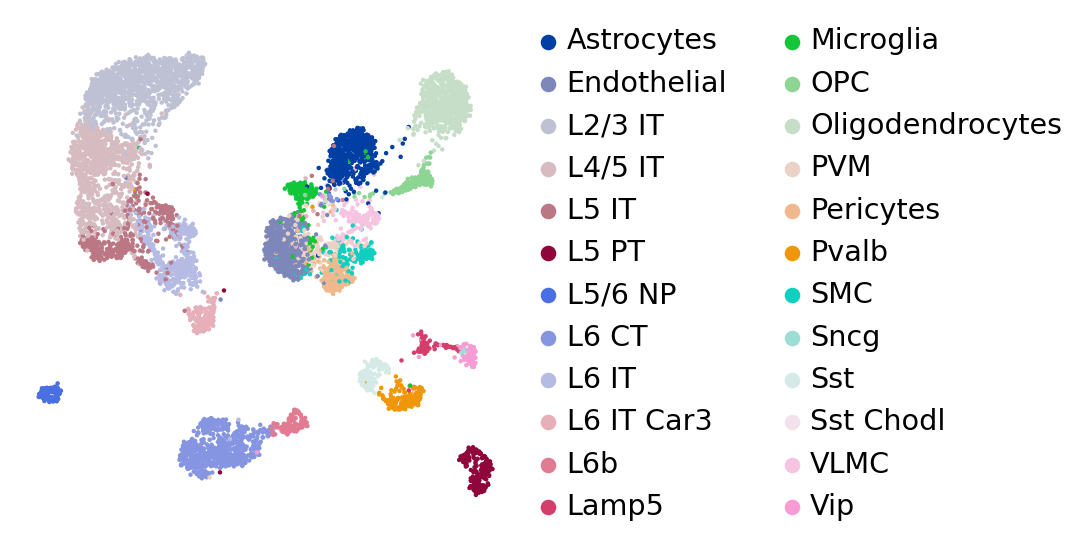

In [17]:
adata = interpreter.data.umap(
    image_key= "mouse1_slice153",
    undefined_type='other',
    n_neighbors=10,
    n_pcs=35,
)

/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:1236: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'subclass_preprocessed' as categorical


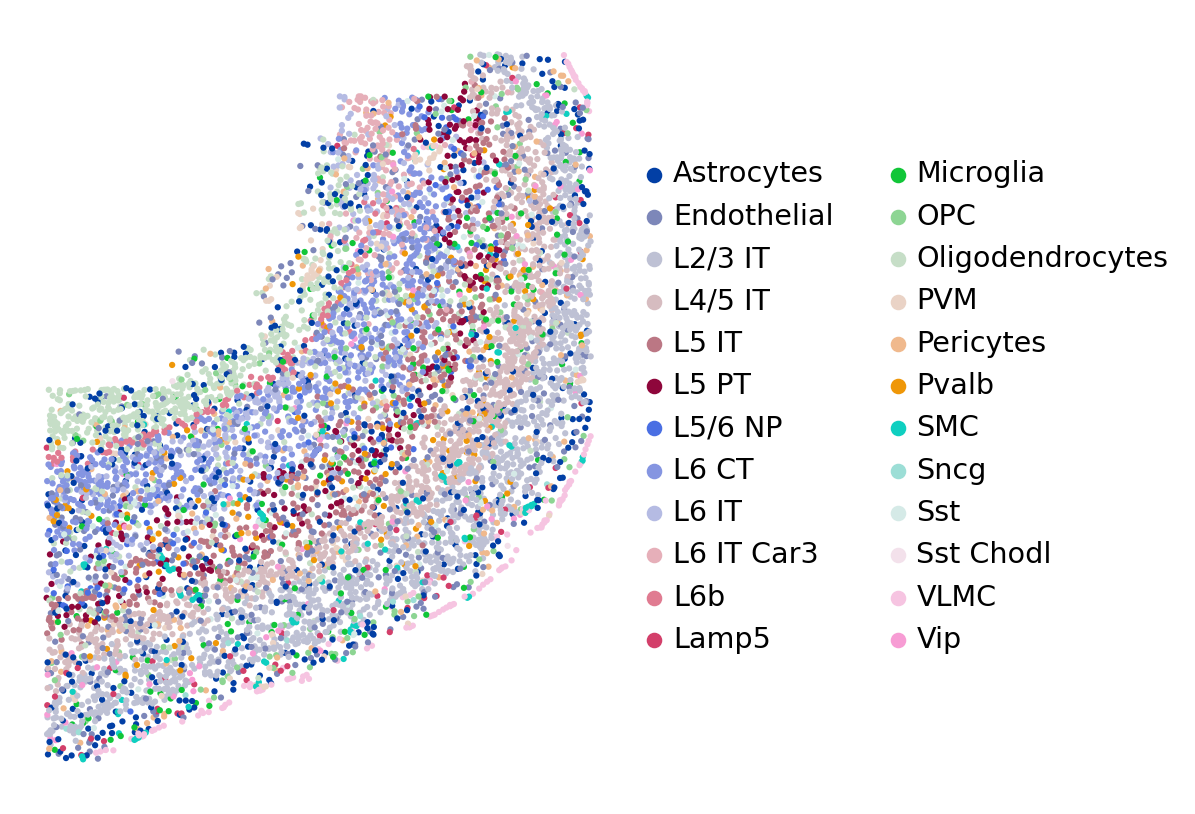

In [18]:
adata = interpreter.data.spatial(
    image_key= "mouse1_slice153",
    undefined_type='other',
    clean_view=True,
    copy=True,
)

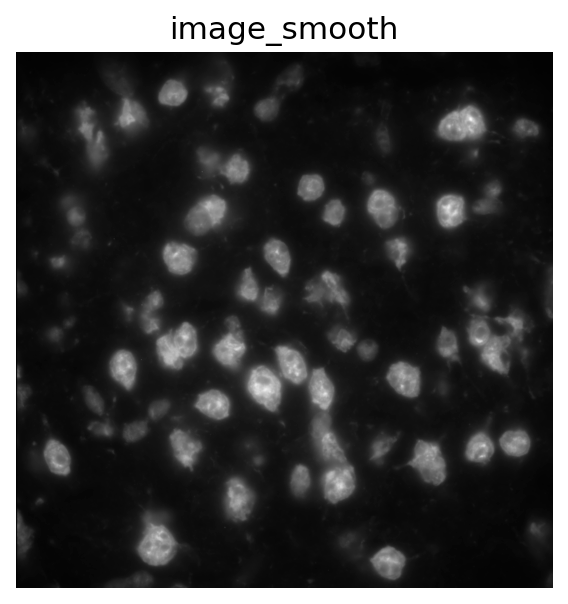

In [19]:
fn = f"{datadir}zhang/processed_images486.tif"
img = Image.open(fn)
images = []
for i in range(img.n_frames):
    img.seek(i)
    images.append(np.array(img))
img.close()

images = np.array(images)
images = np.transpose(images, (1, 2, 0))

# readoutName polyT are in frames [154:160] with zPos (µm) [0.  1.5 3.  4.5 6.  7.5 9. ]
# we show the center z-plane at z=4.5µm
img = sq.im.ImageContainer(images[:, :, 157])
sq.im.process(img)
img.show('image_smooth', cmap="Greys_r", figsize=(4,4))

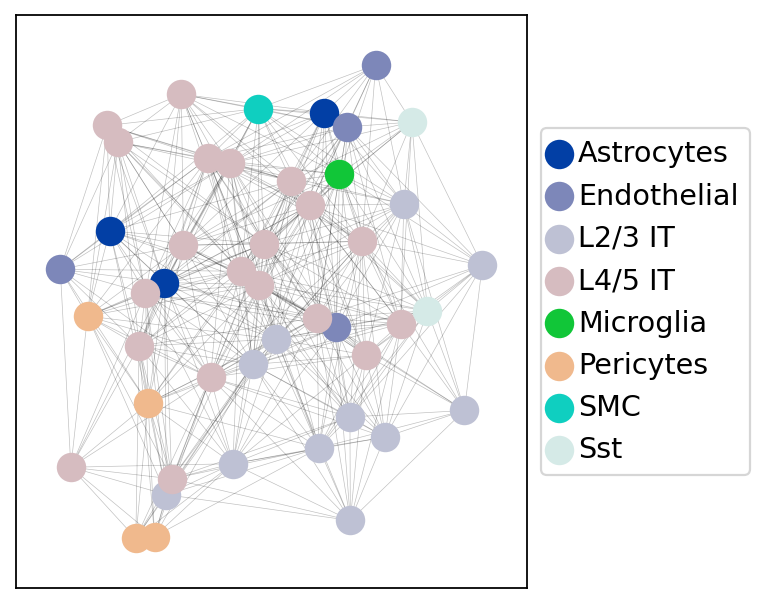

In [20]:
figsize = (5., 4.)
edge_width = 0.3

dataset1_sample3_486 = adata[adata.obs['fovID'] == 486]
dataset1_sample3_486.obsm['spatial'] = dataset1_sample3_486.obsm['spatial']/interpreter.data.celldata.uns['metadata']['lateral_resolution']

h_0 = dataset1_sample3_486.obsm["node_types"]
a = dataset1_sample3_486.obsp["adjacency_matrix_connectivities"]
cell_types = dataset1_sample3_486.obs["subclass_preprocessed"]
if cell_types is None:
    raise ValueError('No cell types for this image available')
# Mask cell types like data batch:
cell_types = cell_types[np.arange(0, a.shape[0])]

cell_type_names = dataset1_sample3_486.uns['node_type_names']

g = nx.from_numpy_matrix(a.todense())
# Include masking of data batch by using h shape:
dict_nodes = {i: np.array(dataset1_sample3_486.obsm["spatial"])[i] for i in np.arange(h_0.shape[0])}

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
nx.draw_networkx_edges(
    g,
    pos=dict_nodes,
    width=edge_width,
    alpha=0.25
)

for i, ctype in enumerate(np.unique(cell_types)):
    # print(ctype)
    #color = [zeileis_28[cell_type_names[ctype]]]
    idx_c = list(np.where(cell_types == ctype)[0])
    nx.draw_networkx_nodes(
        g,
        # with_labels=False,
        node_size=150,
        nodelist=idx_c,
        node_color=dataset1_sample3_486.uns['subclass_preprocessed_colors'][i],
        pos=dict_nodes,
        label=cell_type_names[ctype].replace(
            '_', ' '
        )
    )
box = ax.get_position()
ax.invert_yaxis()
ax.grid(False)
ax.set_position([box.x0, box.y0, box.width, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# Supp. Fig. 1: Cell-type centric summary statistics in MERFISH - brain dataset. 

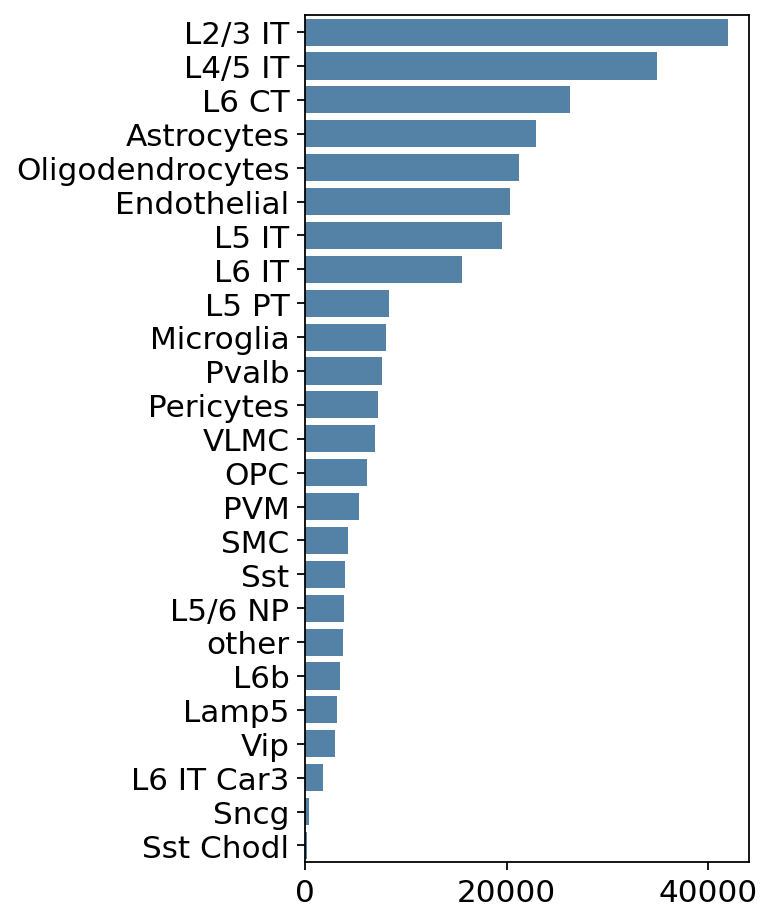

In [21]:
interpreter.data.celltype_frequencies()

0.0
1.2209650177678366
3.373137122402878
11.314344869057322
41.67061117031619
235.36600106608932
810.8033113749502
2334.0417190338585
4380.109375


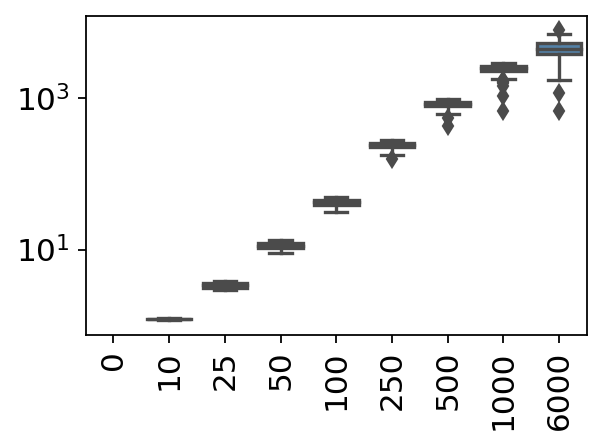

In [22]:
interpreter.data.plot_degree_vs_dist(
    max_distances=[0, 10, 25, 50, 100, 250, 500, 1000, 6000 ],
    lateral_resolution=1,
)

In [ ]:
interpreter.data.celldata_interaction_matrix()

# Supp. Fig. 3: Variance decomposition in spatial omics data sets.

  0%|                                                                                                                      | 0/64 [00:00<?, ?it/s]/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [02:02<00:00,  1.92s/it]


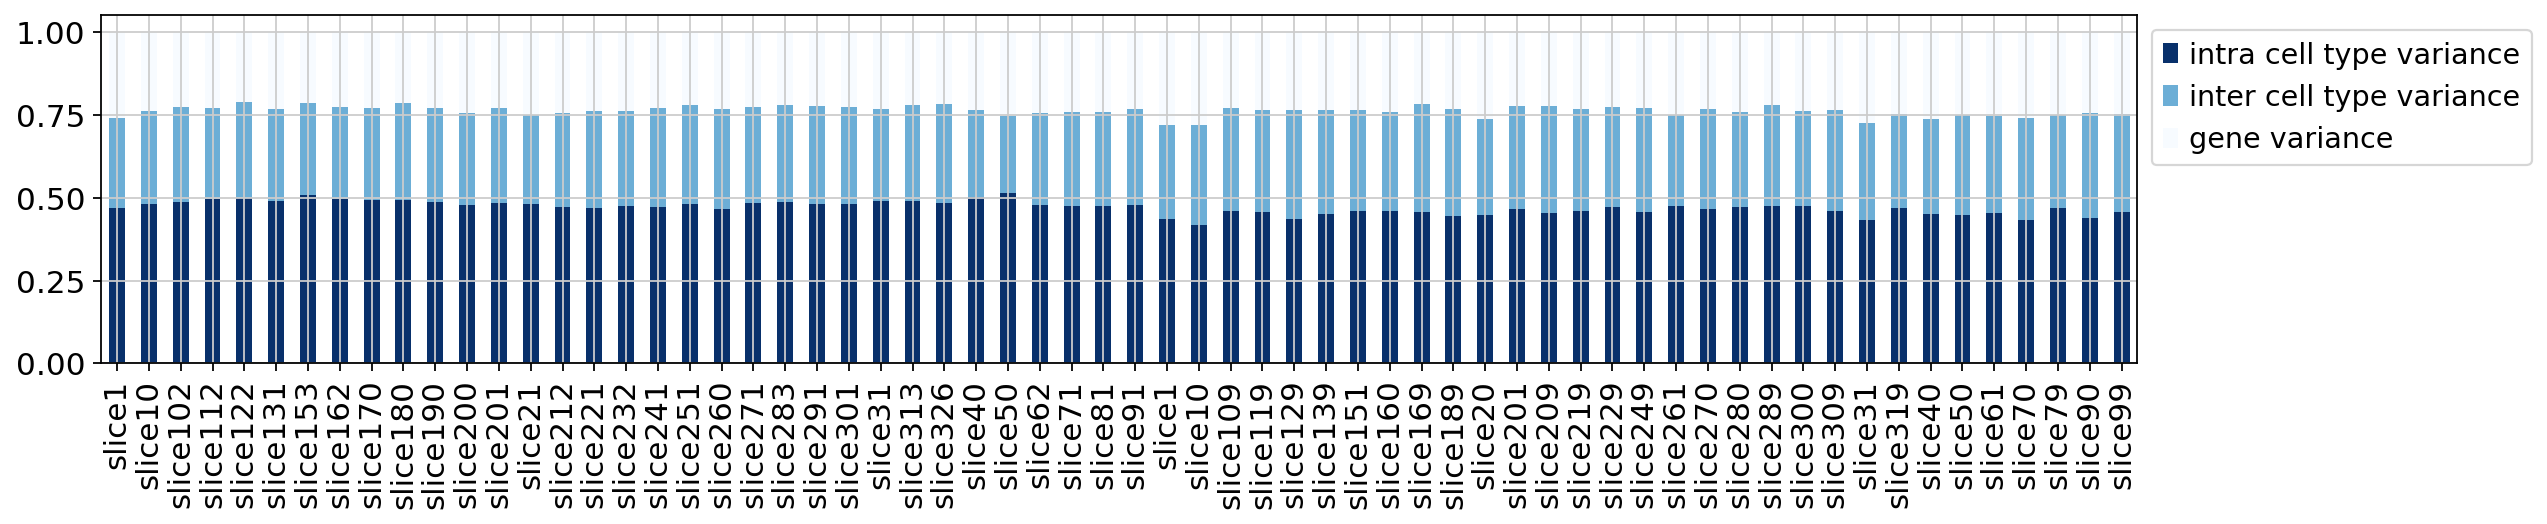

In [23]:
var_decomp = interpreter.data.compute_variance_decomposition(undefined_type='other')
interpreter.data.variance_decomposition(var_decomp, multiindex=True)

In [24]:
var_decomp.mean(axis=0)[['intra cell type variance', 'inter cell type variance', 'gene variance']]

/tmp/ipykernel_180536/3108570045.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  var_decomp.mean(axis=0)[['intra cell type variance', 'inter cell type variance', 'gene variance']]


intra cell type variance    0.470461
inter cell type variance    0.292520
gene variance               0.237020
dtype: float32

# Supp. Figure 9: Attributing cell heterogeneity to niche composition.

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'subclass_preprocessed' as categorical


n cells:  1204
L2/3 IT 0    316
L2/3 IT 1    314
L2/3 IT 2    313
L2/3 IT 3    133
L2/3 IT 4    128
Name: L2/3 IT substates, dtype: int64


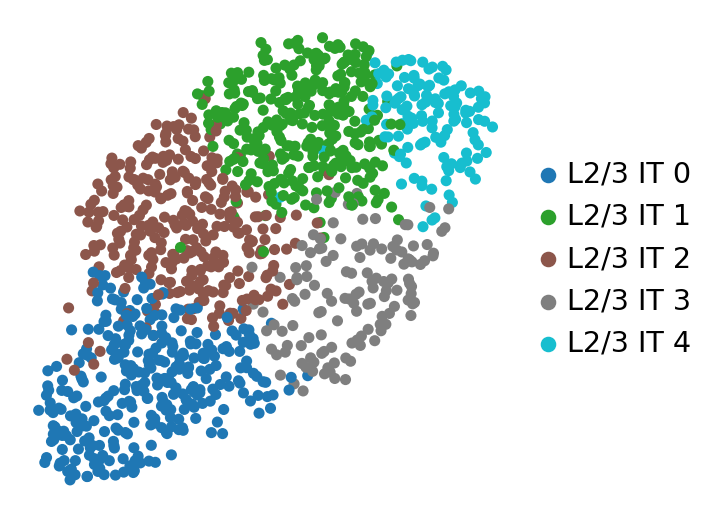

In [25]:
adata = interpreter.data.umap(
    image_key= "mouse1_slice153",
    target_cell_type='L2/3 IT',
    n_neighbors=40,
    n_pcs=40,
    palette='tab10'
)

/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:1236: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'subclass_preprocessed' as categorical
Trying to set attribute `._uns` of view, copying.


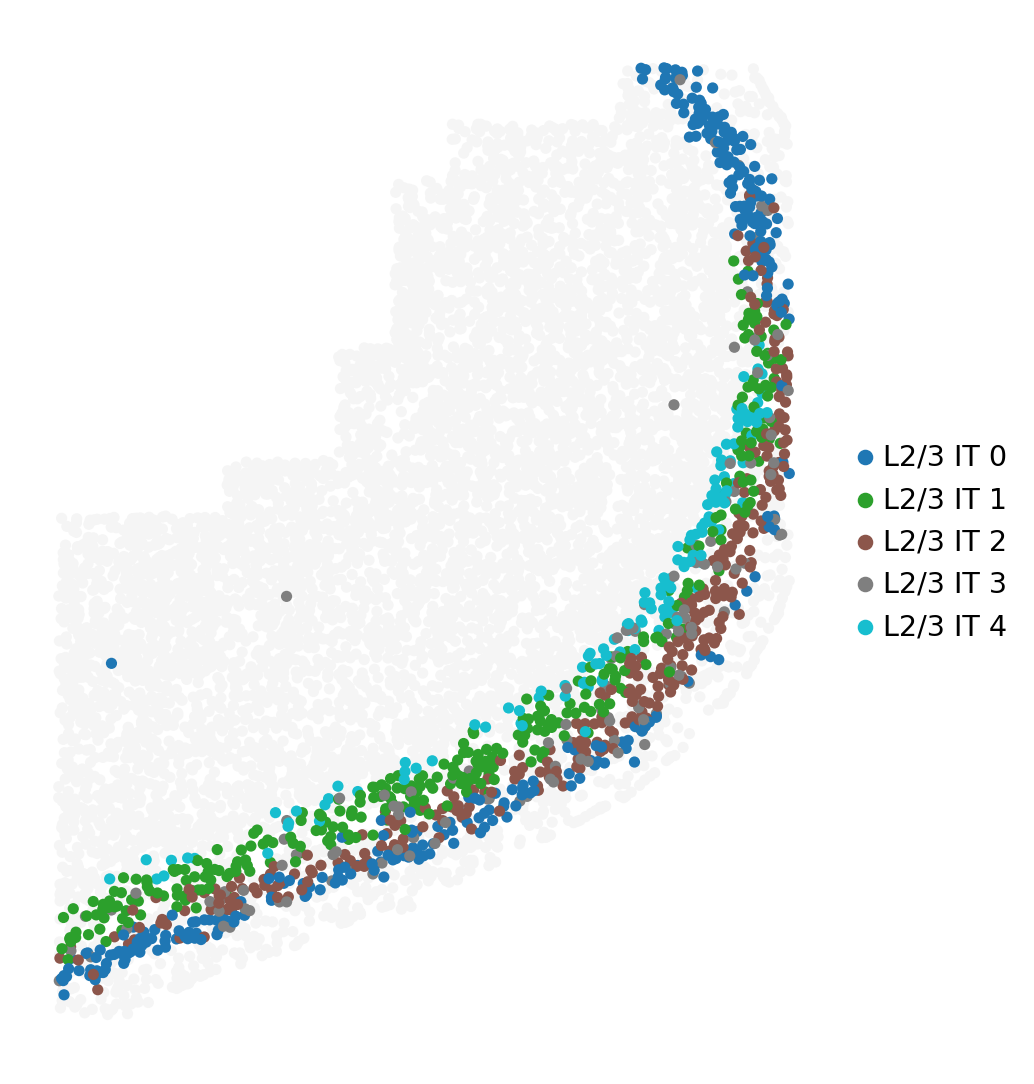

In [26]:
interpreter.data.spatial_substates(
    adata,
    image_key= "mouse1_slice153",
    target_cell_type='L2/3 IT',
    clean_view=True
)

In [27]:
filter_titles = [
    'Oligodendrocytes',
    'Pvalb',
    'L4/5 IT',
    'Sncg',
    'Lamp5',
    'Vip',
    'L5/6 NP',
    'VLMC',
    'L6 IT Car3',
    'Microglia',
    'Endothelial',
    'L5 IT',
    'Sst',
    'OPC',
    'Astrocytes',
    'L2/3 IT',
    'Sst Chodl',
    'Pericytes',
    'SMC',
    'PVM'
]

adata_img, adata, log_pval, fold_change = interpreter.data.compute_cluster_enrichment(
    image_key=['mouse1_slice153'],
    target_cell_type='L2/3 IT',
    undefined_type='other',
    clip_pvalues=-5,
    filter_titles=filter_titles,
    n_neighbors=40,
    n_pcs=40
)

 83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 127/153 [00:42<00:08,  3.09it/s]

         Falling back to preprocessing with `sc.pp.pca` and default params.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 153/153 [00:50<00:00,  3.05it/s]


n cells:  1204
L2/3 IT 0    316
L2/3 IT 1    314
L2/3 IT 2    313
L2/3 IT 3    133
L2/3 IT 4    128
Name: L2/3 IT substates, dtype: int64


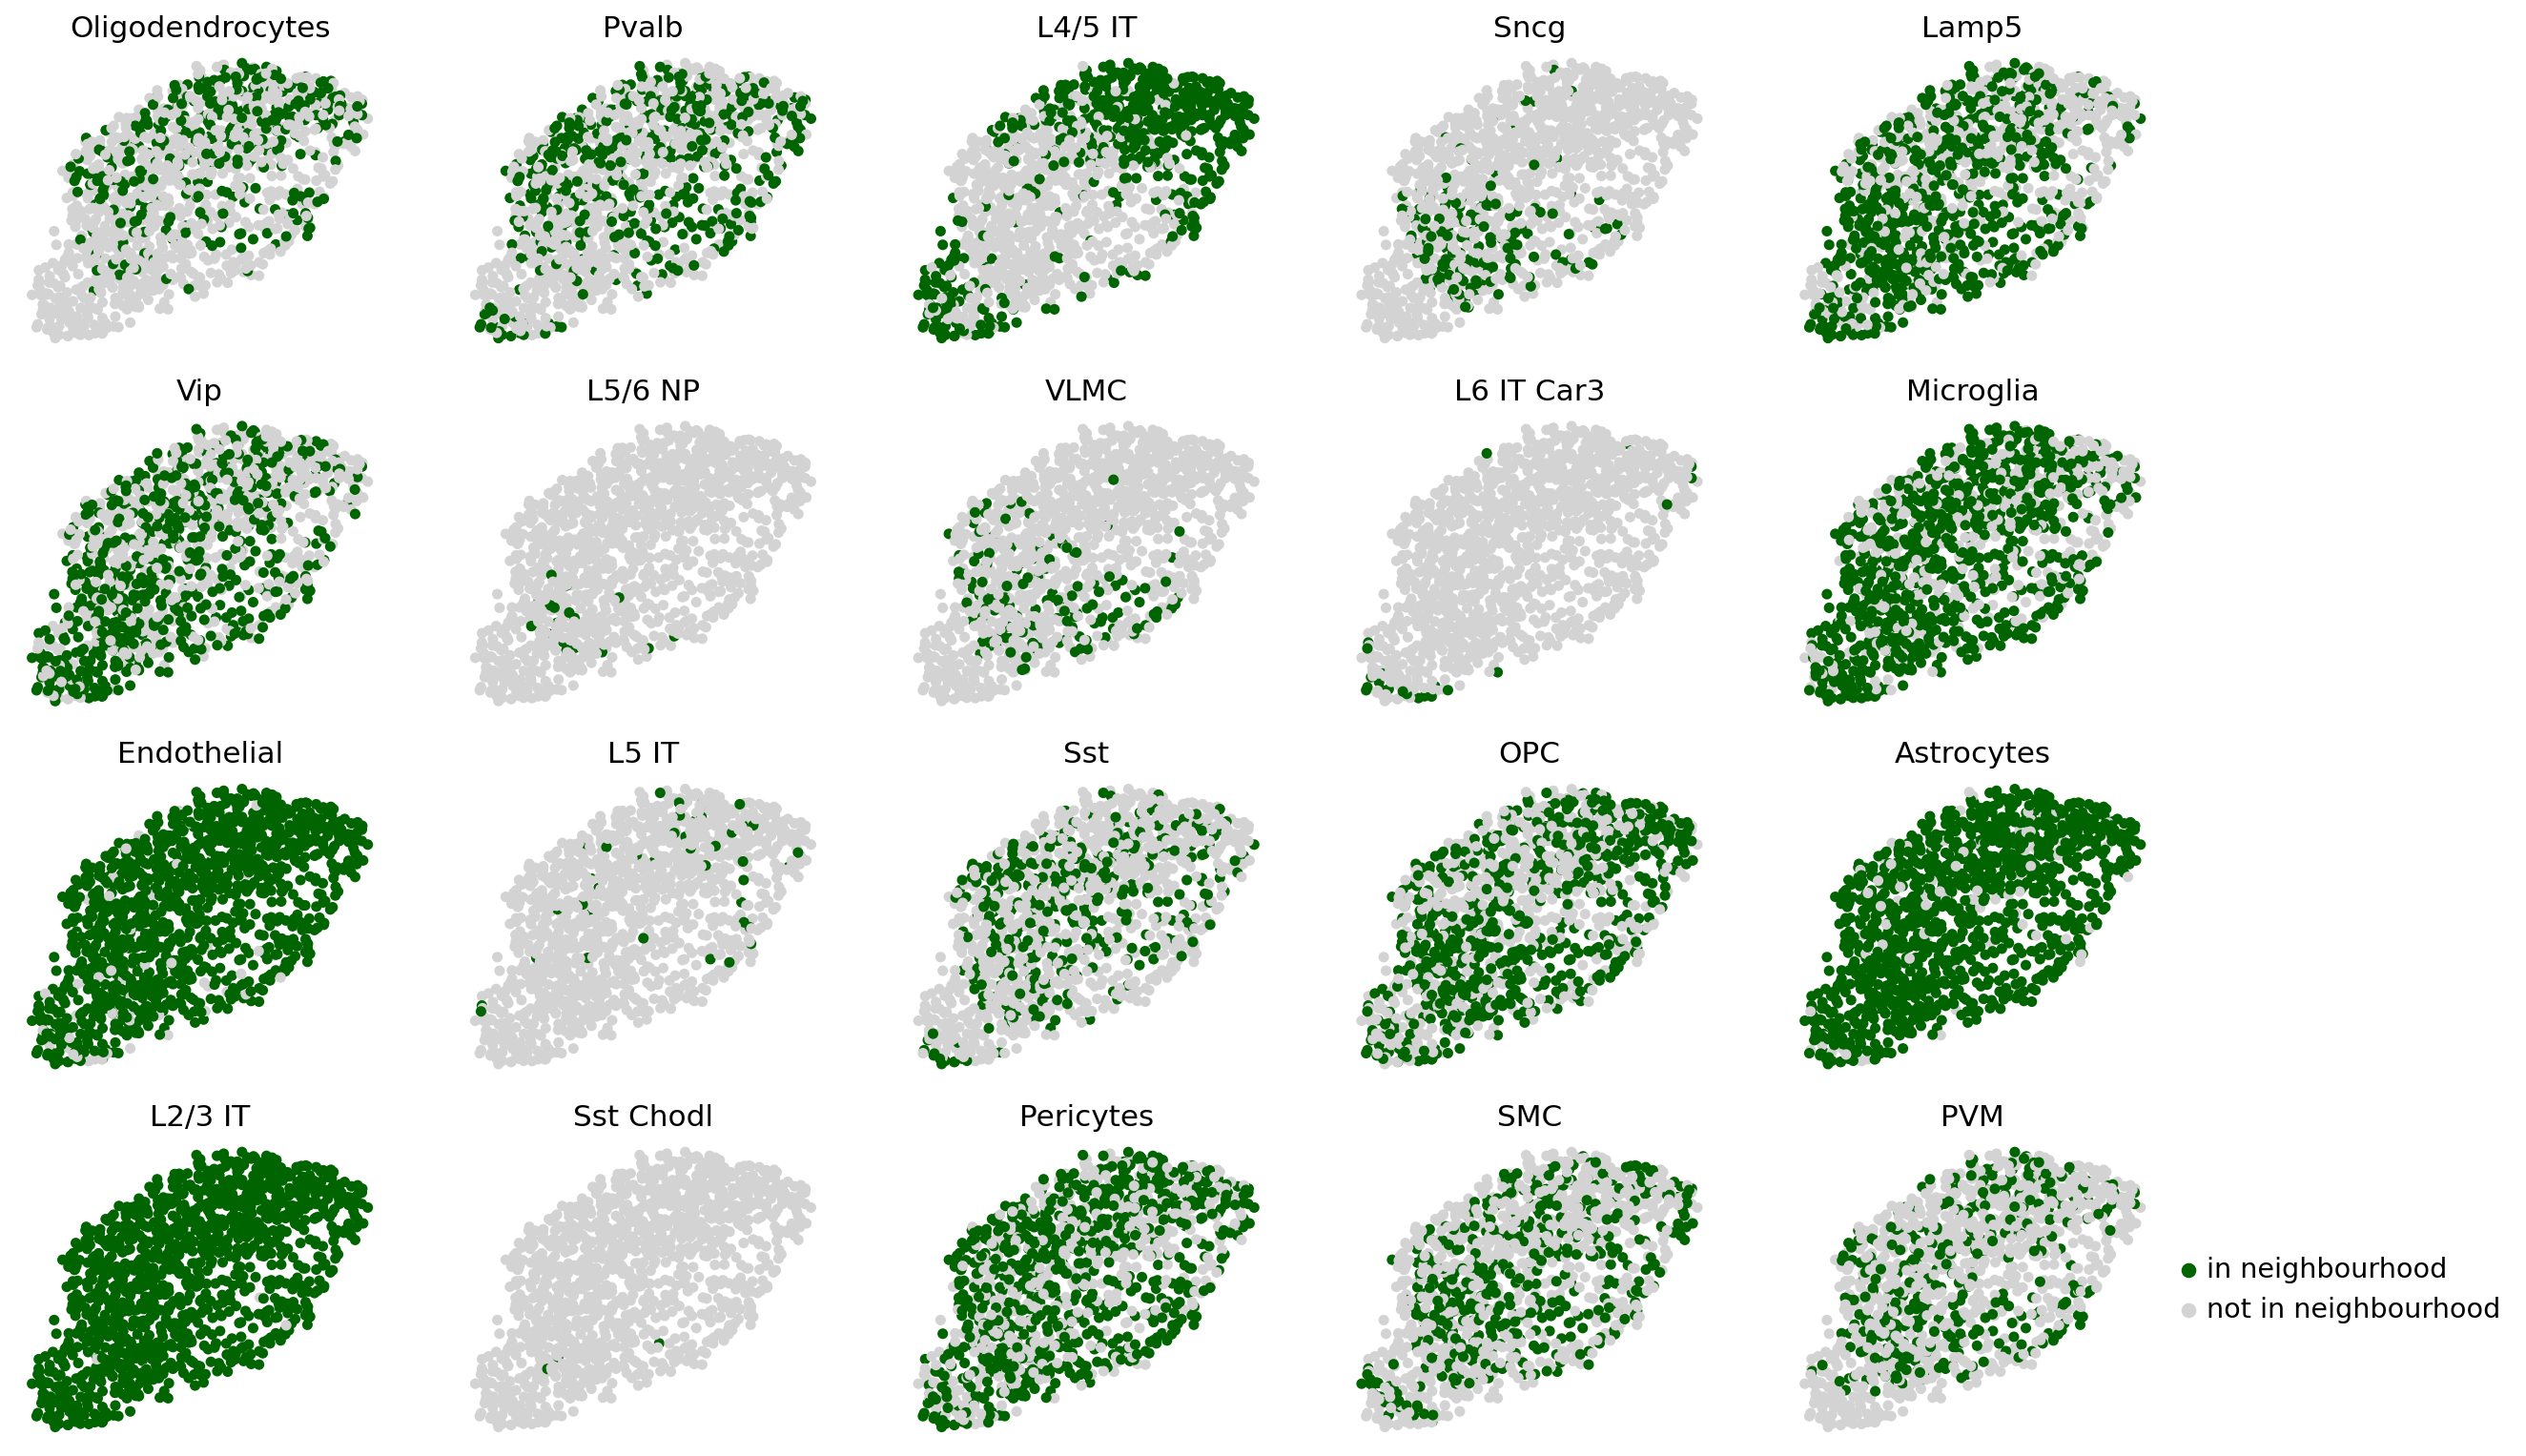

In [30]:
interpreter.data.umaps_cluster_enrichment(adata, filter_titles)

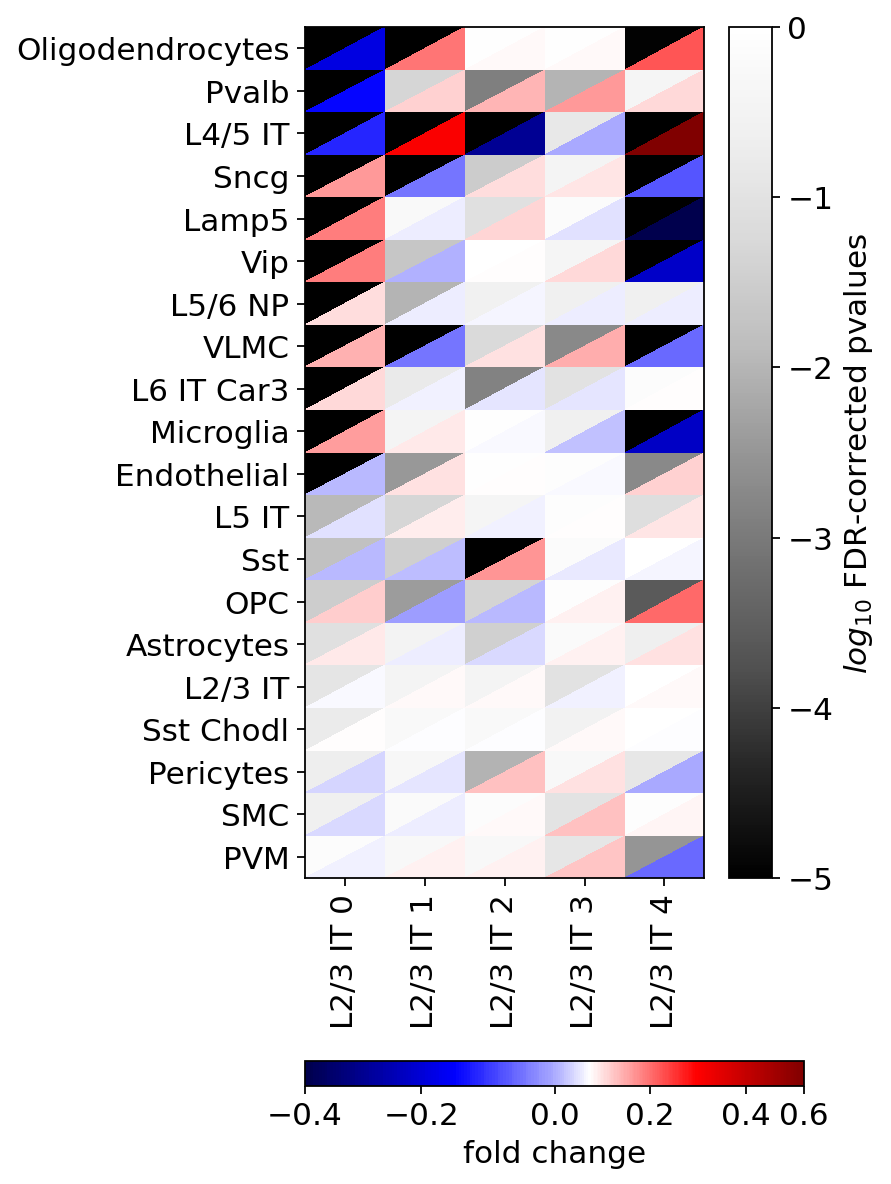

In [40]:
interpreter.data.cluster_enrichment(
    pvalues=log_pval, 
    fold_change=fold_change,
    #linspace=(-0.5, 0.5, 5)
)

# Supp. Fig. 10: Ligand–receptor permutation test.

In [32]:
adata = interpreter.data.ligrec(
    fraction=0.1,
    source_groups='L2/3 IT',
    undefined_type='other',
)

n cells: 27638


/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/squidpy/gr/_ligrec.py:453: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  self._filtered_data = self._data.loc[:, set(self.interactions[SOURCE]) | set(self.interactions[TARGET])]


TypeError: Expected `adata.obs['subclass_preprocessed']` to be `categorical`, found `string`.

In [ ]:
interpreter.data.ligrec_barplot(
    adata,
    source_group='L2/3 IT',
)

In [ ]:
adata = interpreter.data.ligrec(
    image_key= "mouse1_slice153",
    source_groups='L2/3 IT',
    undefined_type='other',
)

In [ ]:
interpreter.data.ligrec_barplot(
    adata,
    source_group='L2/3 IT',
)

# Supp. Fig. 11: Attribution of molecular states to neighborhoods in the MERFISH – brain data set.

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'subclass_preprocessed' as categorical


n cells:  946
L2/3 IT 0    226
L2/3 IT 1    209
L2/3 IT 2    193
L2/3 IT 3    191
L2/3 IT 4    127
Name: L2/3 IT substates, dtype: int64


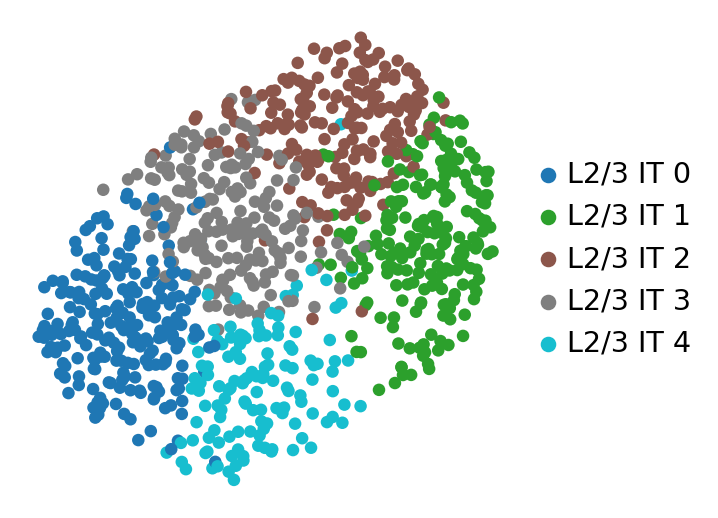

In [41]:
adata = interpreter.data.umap(
    image_key= "mouse1_slice162",
    target_cell_type='L2/3 IT',
    n_neighbors=40,
    n_pcs=40,
    palette='tab10'
)

/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:1236: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'subclass_preprocessed' as categorical


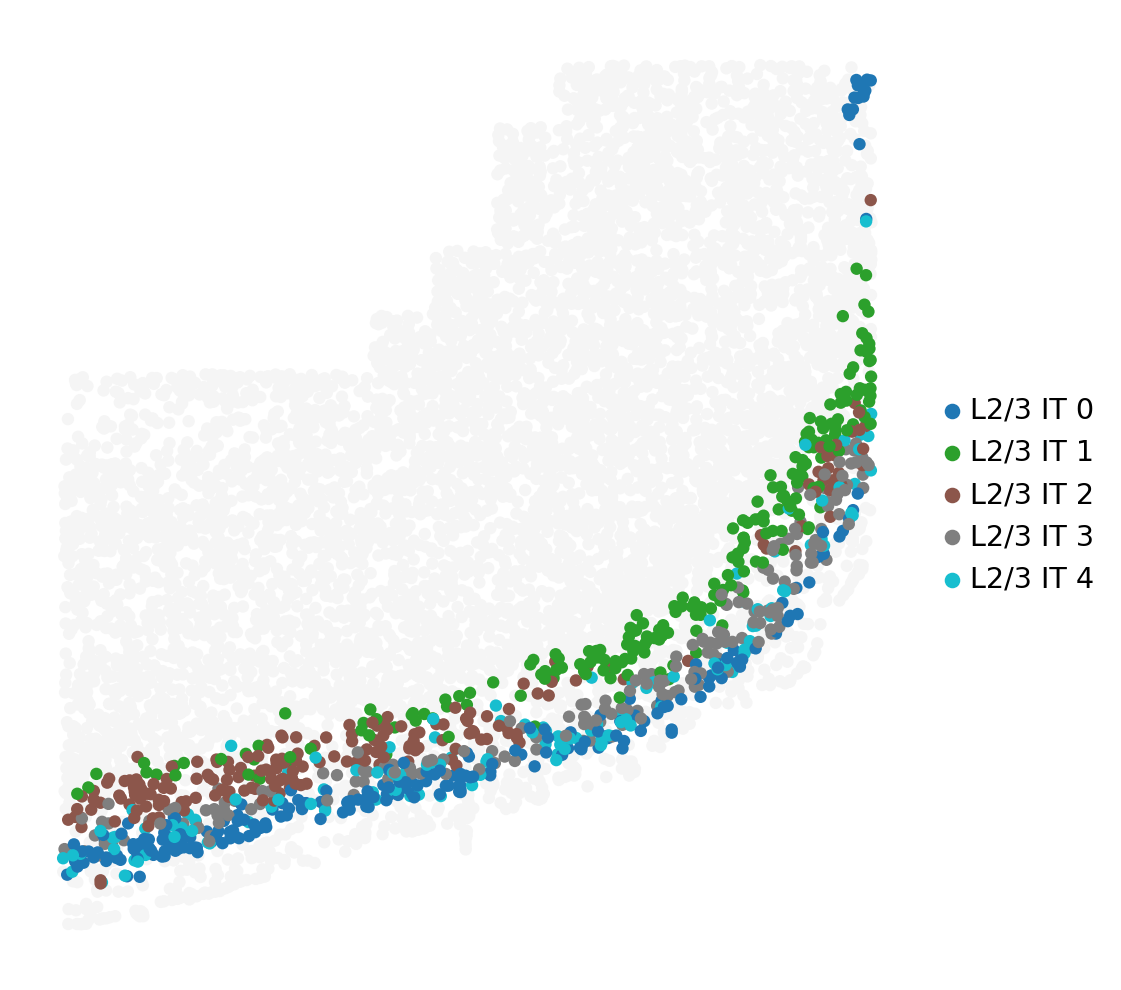

In [42]:
interpreter.data.spatial_substates(
    adata,
    image_key= "mouse1_slice162",
    target_cell_type='L2/3 IT',
)

In [43]:
filter_titles = ['L4/5 IT',
 'VLMC',
 'Pvalb',
 'Sncg',
 'Sst Chodl',
 'SMC',
 'Astrocytes',
 'Lamp5',
 'PVM',
 'L5 IT',
 'Oligodendrocytes',
 'L6 IT',
 'L2/3 IT',
 'Endothelial',
 'Sst',
 'OPC',
 'L6b',
 'Vip',
 'Microglia',
 'Pericytes'
]

adata_img, adata, log_pval, fold_change = interpreter.data.compute_cluster_enrichment(
    image_key=['mouse1_slice162'],
    target_cell_type='L2/3 IT',
    undefined_type='other',
    clip_pvalues=-5,
    n_neighbors=40,
    n_pcs=40,
    filter_titles=filter_titles
)

 83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 127/153 [00:41<00:08,  3.18it/s]

         Falling back to preprocessing with `sc.pp.pca` and default params.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 153/153 [00:47<00:00,  3.19it/s]


n cells:  946
L2/3 IT 0    226
L2/3 IT 1    209
L2/3 IT 2    193
L2/3 IT 3    191
L2/3 IT 4    127
Name: L2/3 IT substates, dtype: int64


/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'slice_id' as categorical
/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sample_id' as categorical
/home/icb/anna.schaar/miniconda3/envs/ncem/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprec

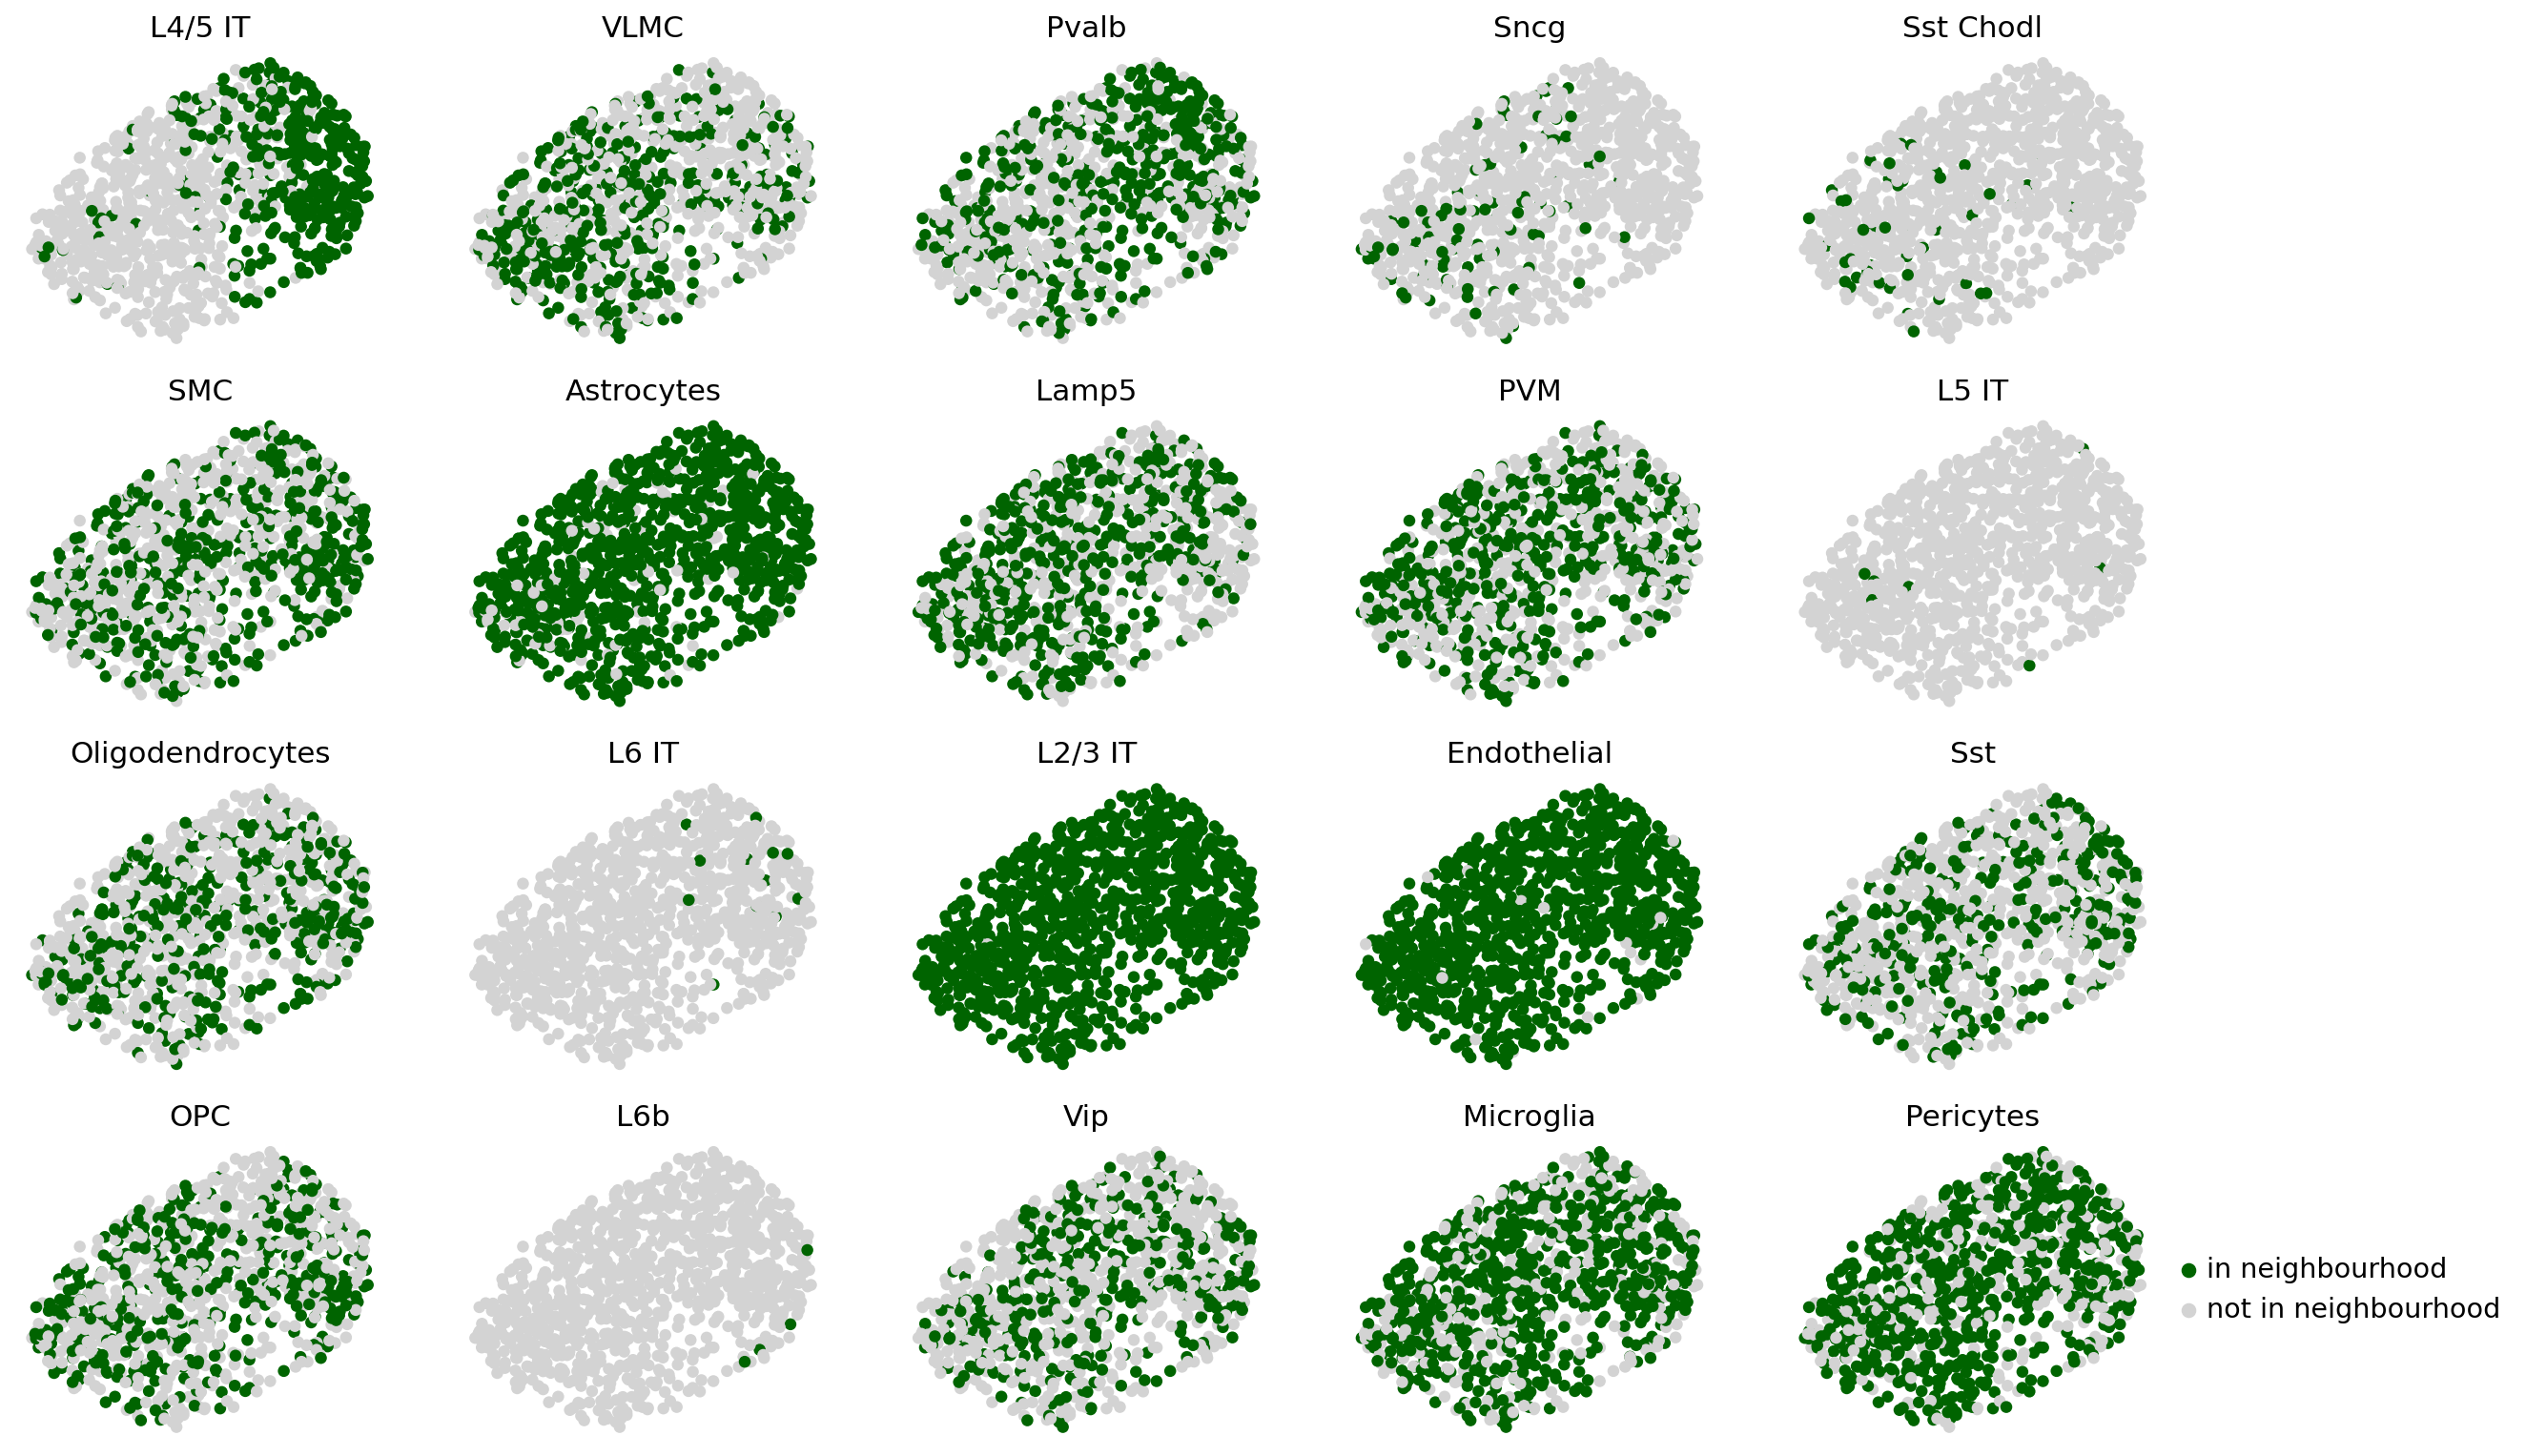

In [44]:
interpreter.data.umaps_cluster_enrichment(adata, filter_titles)

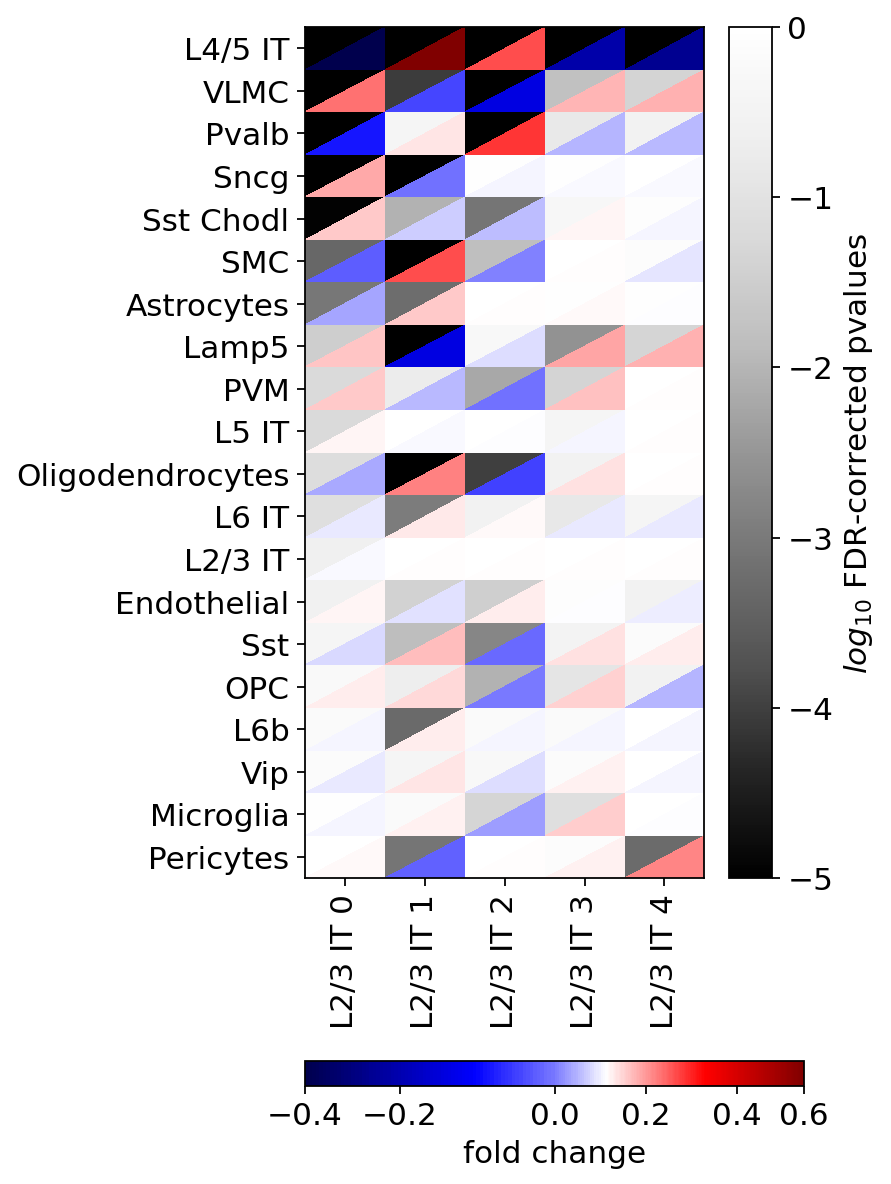

In [46]:
interpreter.data.cluster_enrichment(
    pvalues=log_pval, 
    fold_change=fold_change,
    #linspace=(-0.3, 0.5, 5)
)

# Supp. Fig. 18: Distributional characteristics of gene expression measurements of single cells from spatial molecular profiling assays.

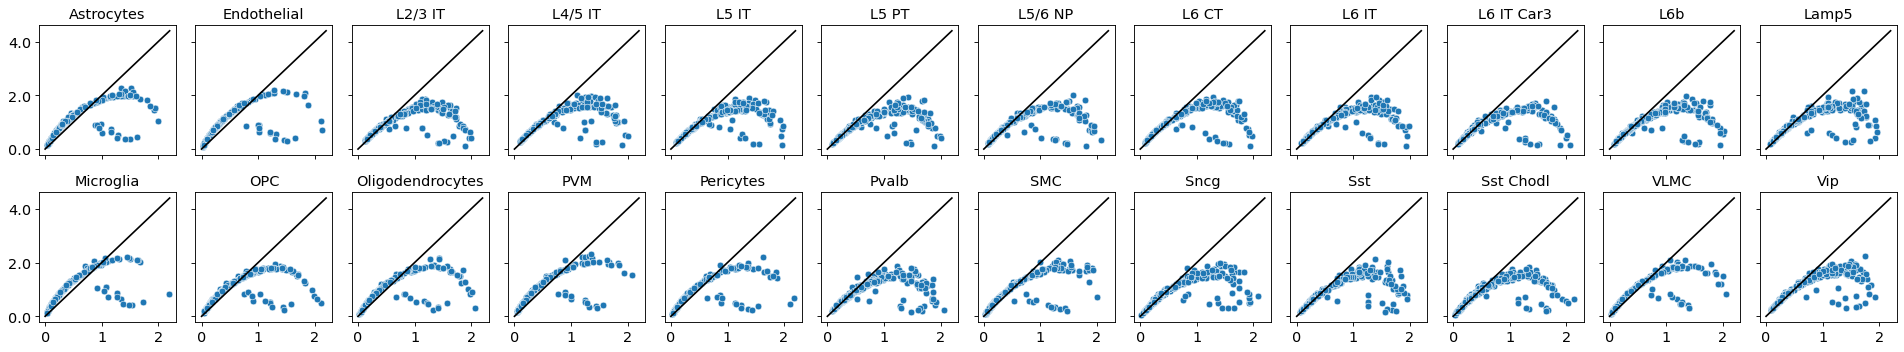

In [27]:
interpreter.data.noise_structure(undefined_type='other', min_x=0.0, max_x=2.2)